# Predicting Bike Rentals

## Introduction

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which you'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

In this project, we'll try to predict the total number of bikes people rented in a given hour. We'll predict the **cnt column** using all of the other columns, **except for casual and registered**. To accomplish this, you'll create a few different machine learning models and evaluate their performance.

## Columns description

Here are the descriptions for the relevant columns:

- **instant** - A unique sequential ID number for each row
- **dteday** - The date of the rentals
- **season** - The season in which the rentals occurred
- **yr** - The year the rentals occurred
- **mnth** - The month the rentals occurred
- **hr** - The hour the rentals occurred
- **holiday** - Whether or not the day was a holiday
- **weekday** - The day of the week (as a number, 0 to 7)
- **workingday** - Whether or not the day was a working day
- **weathersit** - The weather (as a categorical variable)
- **temp** - The temperature, on a 0-1 scale
- **atemp** - The adjusted temperature
- **hum** - The humidity, on a 0-1 scale
- **windspeed** - The wind speed, on a 0-1 scale
- **casual** - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- **registered** - The number of registered riders (people who had already signed up)
- **cnt** - The total number of bike rentals (casual + registered)

## Importing packages and reading dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

pd.options.display.max_rows = 999
%matplotlib inline

In [2]:
bike_rentals = pd.read_csv("my_datasets/bike_rental_hour.csv")

## Exploring dataset

In [3]:
print("Dataset shape:",bike_rentals.shape)
bike_rentals.head()

Dataset shape: (17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

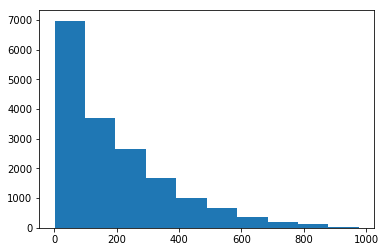

In [4]:
plt.hist(bike_rentals["cnt"])

                 cnt
cnt         1.000000
registered  0.972151
casual      0.694564
temp        0.404772
atemp       0.400929
hr          0.394071
hum         0.322911
instant     0.278379
yr          0.250495
season      0.178056
weathersit  0.142426
mnth        0.120638
windspeed   0.093234
holiday     0.030927
workingday  0.030284
weekday     0.026900


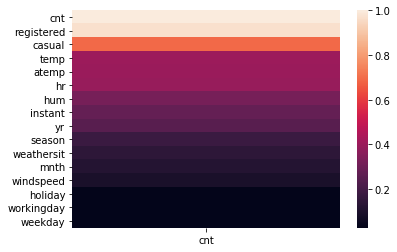

In [5]:
abs_correlation = bike_rentals.corr().abs().sort_values(by="cnt", ascending = False)[["cnt"]]
sns.heatmap(abs_correlation)
print(abs_correlation)

## Calculating Features

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

For example, the hr column in bike_rentals contains the hours during which bikes are rented, from **1 to 24**. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for **morning, afternoon, evening, and night**. This will bundle similar times together, enabling the model to make better decisions.

In [6]:
def assign_label(hr):
    if hr < 6:
        label = 4
    elif hr < 12:
        label = 1
    elif hr < 18:
        label = 2
    elif hr < 24:
        label = 3
    return label

In [7]:
bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)
bike_rentals["time_label"].value_counts()

2    4375
3    4368
1    4360
4    4276
Name: time_label, dtype: int64

## Splitting the Data into Train and Test sets

Before splitting the data into train and test sets, we will chose an error metric to evaluate the performance of the models.

Considering that **cnt is a continuos numeric column**, the **mean squared error** makes the most sense to evaluate our error. **MSE** works on continuous numeric data, which fits our target quite well.

In [8]:
bike_rentals["time_label"] = bike_rentals["time_label"].astype("category")
bike_rentals["weathersit"] = bike_rentals["weathersit"].astype("category")
bike_rentals["weekday"] = bike_rentals["weekday"].astype("category")

In [9]:
## random_state=1 to always have the same numbers in the project
train = bike_rentals.sample(frac=0.8, random_state=1)
train_index = train.index
test = bike_rentals.drop(train_index)

In [10]:
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)

## Applying Linear Regression

Linear regression will probably work fairly well on this data, given that many of the columns are highly correlated with cnt.

We'll need to ignore the casual and registered columns because cnt is derived from them. If we're trying to predict the number of people who rent bikes in a given hour (cnt), it doesn't make sense that we'd already know casual or registered, because those numbers are added together to get cnt.

In [12]:
exclude_columns = ["cnt","casual","dteday","registered","hr","instant","temp","yr"]
predictors = list(bike_rentals.columns.drop(exclude_columns))
target = "cnt"
print(predictors)

['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed', 'time_label']


In [13]:
lr = LinearRegression()
lr.fit(train[predictors],train[target])

predictions = lr.predict(test[predictors])
error = mean_squared_error(predictions, test[target])
print("Linear Regression error (MSE):", error)

Linear Regression error (MSE): 20166.999885732483


The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

## Applying Decision Trees

In [14]:
#Default Decision Tree Regressor
dtr = DecisionTreeRegressor()
dtr.fit(train[predictors],train[target])
predictions = dtr.predict(test[predictors])
error = mean_squared_error(predictions, test[target])
print("Default Decision Tree Regressor error (MSE):", error)

Default Decision Tree Regressor error (MSE): 23475.081974811405


In [15]:
#Default Decision Tree Regressor
dtr = DecisionTreeRegressor(min_samples_leaf=10)
dtr.fit(train[predictors],train[target])
predictions = dtr.predict(test[predictors])
error = mean_squared_error(predictions, test[target])
print("Min_samples_leaf=10 Decision Tree Regressor error (MSE):", error)

Min_samples_leaf=10 Decision Tree Regressor error (MSE): 15262.869832733693


In [48]:
#Min_samples_leaf=20 Decision Tree Regressor
dtr = DecisionTreeRegressor(min_samples_leaf=20)
dtr.fit(train[predictors],train[target])
predictions = dtr.predict(test[predictors])
error = mean_squared_error(predictions, test[target])
print("Min_samples_leaf=20 Decision Tree Regressor error (MSE):", error)

Min_samples_leaf=20 Decision Tree Regressor error (MSE): 14791.274505983665


In [27]:
dtr.tree_.max_depth

19

After experimenting with the min_samples_leaf parameter, we lowered the MSE to 14791.

## Applying Random Forests

In [46]:
#Default Random Forest Regressor
rf = RandomForestRegressor(n_estimators=10, random_state=1)
rf.fit(train[predictors],train[target])
predictions = rf.predict(test[predictors])
error = mean_squared_error(predictions, test[target])
print("Default Random Forest Regressor error (MSE):", error)

Default Random Forest Regressor error (MSE): 14088.955716343467


In [49]:
#Min_samples_leaf=20 - n_estimators=10 Random Forest Regressor
rf = RandomForestRegressor(n_estimators=10, min_samples_leaf=20, random_state=1)
rf.fit(train[predictors],train[target])
predictions = rf.predict(test[predictors])
error = mean_squared_error(predictions, test[target])
print("Min_samples_leaf=20 Random Forest Regressor error (MSE):", error)

Min_samples_leaf=20 Random Forest Regressor error (MSE): 13821.66558273775


In [50]:
#Min_samples_leaf=20 - n_estimators=100 Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=20, random_state=1)
rf.fit(train[predictors],train[target])
predictions = rf.predict(test[predictors])
error = mean_squared_error(predictions, test[target])
print("Min_samples_leaf=20 Random Forest Regressor error (MSE):", error)

Min_samples_leaf=20 Random Forest Regressor error (MSE): 13491.513334848205


After experimenting with the min_samples_leaf and n_estimators parameters, we lowered the MSE to 13491.